# Mean Reversion Trading
## Ming-Chun Wu


### Introduction
In this notebook, we are going to explore mean reversion strategies for pairs trading. In particular, we will be looking at S&P 500 index and Russell 2000 index.
We first import downloaded 10-year historical data from Yahoo finance. 

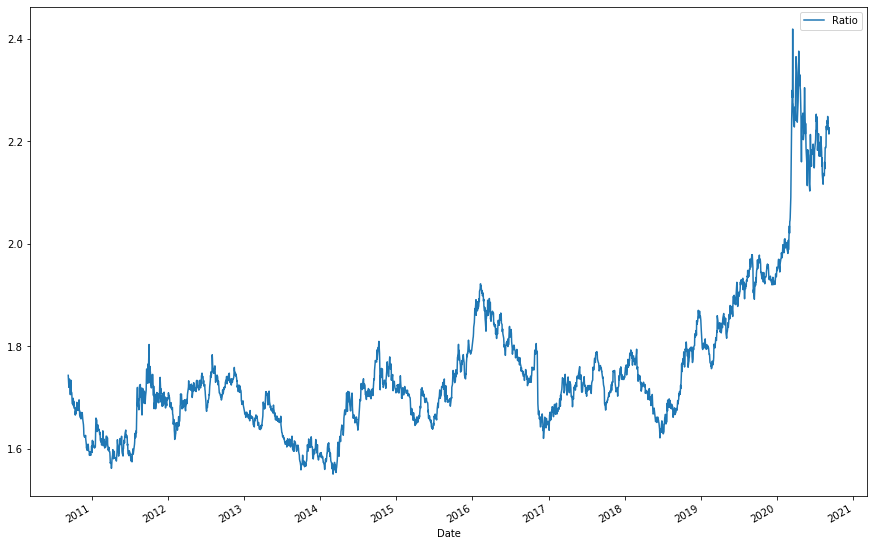

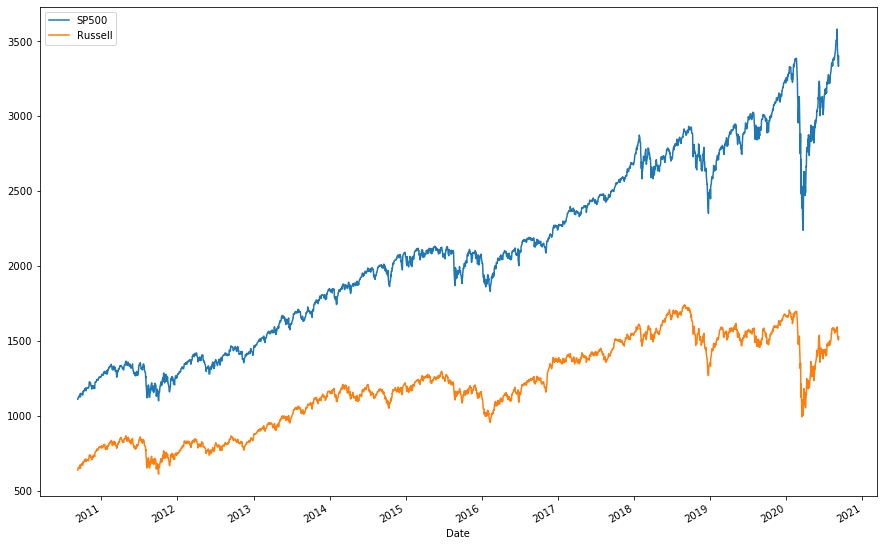

,SP500,Russell,Ratio
Date,,,
2010-09-10,1109.550049,636.460022,1.743315
2010-09-13,1121.900024,652.280029,1.719967
2010-09-14,1121.099976,649.229980,1.726815
2010-09-15,1125.069946,652.510010,1.724219
2010-09-16,1124.660034,647.809998,1.736096
...,...,...,...
2020-09-02,3580.840088,1592.290039,2.248862
2020-09-03,3455.060059,1544.680054,2.236748
2020-09-04,3426.959961,1535.300049,2.232111


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# load data
sp500 = pd.read_csv("SP500.csv")
russell = pd.read_csv("Russell.csv")

dateIndex = pd.to_datetime(sp500.loc[:, "Date"], format = "%Y/%m/%d");
df = pd.DataFrame({"SP500":sp500["Close"], "Russell": russell["Close"]})
df["Ratio"] = df["SP500"]/df["Russell"];
df.set_index(dateIndex, inplace = True)

# train-test split
nSamples = len(df);
nTrain = int(nSamples * 0.7);
nValidate = int(nSamples * 0.15);

train = df[:nTrain];
validate = df[nTrain:(nTrain+nValidate)];
test = df[(nTrain+nValidate):]

df[["Ratio"]].plot(figsize=(15,10));
df[["SP500", "Russell"]].plot(figsize=(15,10));
plt.show();

df

We can see that the SP500 index and the Russell 2000 index have similar patterns on the training set, and it seems that the ratio is mean-reverting. If the ratio is mean-reverting, we may be able to develope an algorithmic trading strategy that is profitable. 

### Mean Reversion
A continuous mean-reverting time series $y_t$ can be represented by an Ornstein-Uhlenbeck (OU) stochastic differential equation:
$$ dy_t = \lambda (\mu - y_t)dt + \sigma dW_t$$
Where $\mu$ is the rate of reversion to the mean, $\mu$ is the mean value of the process, $\sigma$ is the variance of the process and $W_t$ is a Wiener Process or Brownian Motion. We have the following solutions to the formula:
$$y_t = e^{-\lambda dt} y_{t-1} + (1 - e^{-\lambda dt})\mu + 
\sigma \sqrt{\frac{1 - e^{-2\lambda dt}}{2\lambda}}dW_t$$

$$\mathbb{E}[y_t] = y_0e^{-\lambda t} + \mu (1 - e^{-\lambda t})$$

$$\mathrm{var}(x_t) = \frac{\sigma^2}{2\lambda} (1 - e^{-2\lambda t})$$

We can check if the ratio follows the OU formula. For discrete time series, we can use the ***Augmented Dickey-Fuller Test***. For our case, we have p-value 0.105142, which implies that ratio is somewhat mean reverting.

In [2]:
from statsmodels.tsa.stattools import adfuller

adfTest=adfuller(train["Ratio"], maxlag=1, regression='c', autolag=None)

print('ADF Statistic: %f' % adfTest[0])
print('p-value: %f' % adfTest[1])
print('Critical Values:')
for key, value in adfTest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.543955
p-value: 0.105143
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### Fitting Ornstein-Uhlenbeck
We now fit the Ornstein-Uhlenbeck model to the training data. There are three parameters $\mu, \lambda, \sigma$ to be estiamted. A simple yet effective method is the Least Squre Estimator. We rewrite the OU formula (intuitively)
$$y_t - y_{t-1} = \lambda\mu dt - \lambda dt y_{t-1}+ \sigma dW_t$$
Compare it to the linear regression model:
$$y = a + bx + e, \ e \sim N(0, \epsilon^2)$$
It suggests us fit a linear regression on $\{y_t - y_{t-1}\}$ and $\{y_{t-1}\}$. Suppose we get the least square estimations $\hat{a}, \hat{b}, \hat\epsilon$, we have
$$\hat{\lambda} = \frac{-\hat{b}}{dt}$$
$$\hat{\mu} = \frac{\hat{a}}{\hat{\lambda}dt}$$
$$\hat{\sigma} = \frac{\hat{\epsilon}}{\sqrt{dt}}$$


For our case, we replace $y_t$ with its discrete version $y[t]$ and let $dt = 1$.

(Note: we can also use MLE for parameter estimation. However, there won't be much difference in terms of the performance of trading strategies)

In [3]:
import statsmodels.api as sm

def simulateOU(y0, mu, sigma, lmda, dt, t):
    n = int(t/dt);
    y = np.zeros(n);
    y[0] = y0;
    exp = np.exp(-lmda*dt);
    if (lmda == 0):
        dWt = np.sqrt(dt)*np.random.randn(n);
    else:
        dWt = np.sqrt((1-np.exp(-2*lmda*dt))/(2*lmda)) * np.random.randn(n);
    for i in range(1, n):
        y[i] = y[i-1]*exp + mu*(1-exp) + sigma*dWt[i];
    return y;

def getLSEstimator(data, dt):
    y = pd.Series(data);
    ylag = y.shift();
    ydelta = y - ylag;
    ylag = sm.add_constant(ylag);
    ylag.columns = ["const", "ylag"];
    model = sm.OLS(ydelta[1:], ylag[1:]);
    res = model.fit();
    a = res.params["const"];
    b = res.params["ylag"];
    epsilon = res.resid.std(ddof=2);
    return (a/-b, epsilon/np.sqrt(dt), -b/dt, res);

# for debugging
# mu, sigma, lmda, dt, t = 0.19, 1.1, 16, 1/50, 250;
# ySimu = simulateOU(0.15, mu, sigma, lmda, dt, t);
# muHat, sigmaHat, lmdaHat, res = getLSEstimator(ySimu, dt);
# print(mu, sigma, lmda);
# print(muHat, sigmaHat, lmdaHat);

mu, sigma, lmda, res = getLSEstimator(train["Ratio"],1);

### Stationarity
Now we have the estimated parameters of the OU process. From 
$$\mathbb{E}[y_t] = y_0e^{-\lambda t} + \mu (1 - e^{-\lambda t})$$
$$\mathrm{var}(x_t) = \frac{\sigma^2}{2\lambda} (1 - e^{-2\lambda t})$$
we know the stationary mean and variance are:
$$\mu, \frac{\sigma^2}{2\lambda}$$
From our estimations:

In [4]:
var = sigma/np.sqrt(2*lmda);
print("=== Training === ")
print("Estimated Stationary Mean:", mu);
print("Time Average Mean:", train["Ratio"].mean());

print("Estimated Stationary Standard Deviation:", var); 
print("Time Average Standard Deviation:", train["Ratio"].std());

=== Training === 
Estimated Stationary Mean: 1.6974931235447042
Time Average Mean: 1.6962821600210274
Estimated Stationary Standard Deviation: 0.07205520718305014
Time Average Standard Deviation: 0.07169524738188385


We know that if a time series is stationary, it is also an ergodic time series. A time series is said to be ergodic if its statistical properties can be deduced from a single, sufficiently long, random sample of the process. Briefly speaking, its stationary mean is equal to its time average mean and its stationary variance is equal to its time average variance. It is quite true for our case. ***Therefore, we can be quite confidence that the ratio is a stationary mean reverting time series.***

### Prediction
However, ratio may not stay stationary forever. If we fit the OU model on the test set, we can see that parameters of the OU model change.

In [5]:
muTest, sigmaTest, lmdaTest, resTest = getLSEstimator(test["Ratio"],1);
varTest = sigmaTest/np.sqrt(2*lmdaTest);
print("=== Testing === ")
print("Estimated Stationary Mean:", muTest);
print("Time Average Mean:", test["Ratio"].mean());

print("Estimated Stationary Standard Deviation:", varTest); 
print("Time Average Standard Deviation:", test["Ratio"].std());

=== Testing === 
Estimated Stationary Mean: 2.1415424327007795
Time Average Mean: 2.0203024375672967
Estimated Stationary Standard Deviation: 0.14832517902003142
Time Average Standard Deviation: 0.15126554448667104


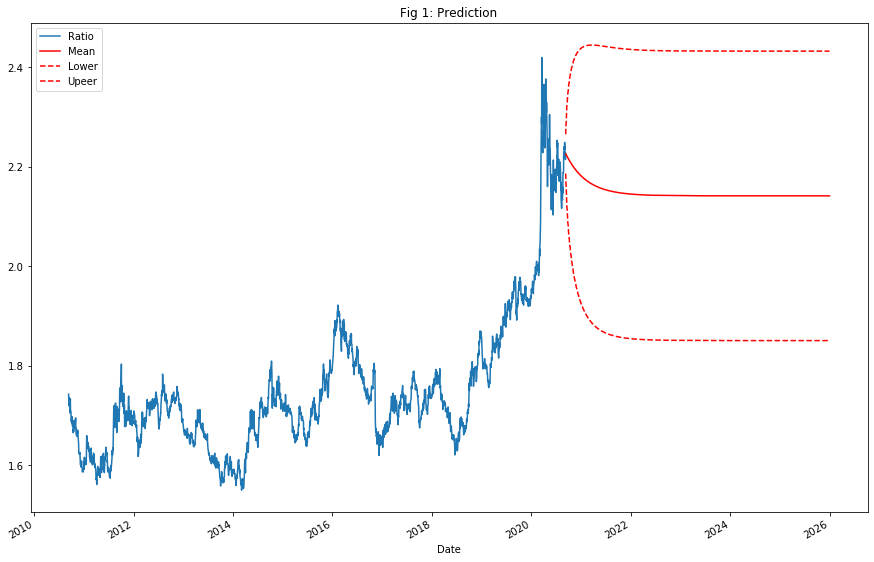

Mean: 2.1415424327007795
95 Confidence Interval: [1.386687, 2.896397]


In [6]:
def predict(y0, mu, sigma, lmda, dt, n):
    t = np.arange(n) + 1
    exp = np.exp(-lmda * t);
    mean = y0*exp + mu*(1-exp);
    
    var = (sigma**2)/(2*lmda)*(1 - np.exp(-2*lmda*t));
    return mean, np.sqrt(var)

date = pd.date_range(start='9/10/2020', end='12/31/2025')
date = date[date.dayofweek < 5]

m, s = predict(2.226665, muTest, sigmaTest, lmdaTest, 1, len(date));
predict = pd.DataFrame( {"Mean":m, "Lower": m - 1.96*s, "Upeer": m + 1.96*s});
predict.set_index(date, inplace=True);

ax = df[["Ratio"]].plot(figsize=(15,10))
predict.plot(ax=ax, color=['r', 'r', 'r'], style = ["-", "--", "--"])
plt.title("Fig 1: Prediction");
plt.show()

print("Mean:", muTest);
print("95 Confidence Interval: [%f, %f]" % (muTest - 1.96*np.sqrt(varTest), muTest + 1.96*np.sqrt(varTest)) )

### Linear Mean Reverting Trading
Given that raio is mean-reverting, we use it as signal for trading. The basic idea is that the signal should go back to its mean from deviations. If the signal is too high, we take short position. If the signal is too low, we take long positions. 

We describe the first approache -- linear mean reverting: We hold position negatively proportion to the deviation of the signal from its mean. Since the signal might not be perfectly stationary foreever, we use moving average to compute mean and standard deviation. The length of the moving average window is set to be the estimated halflife of the signal from the training data.

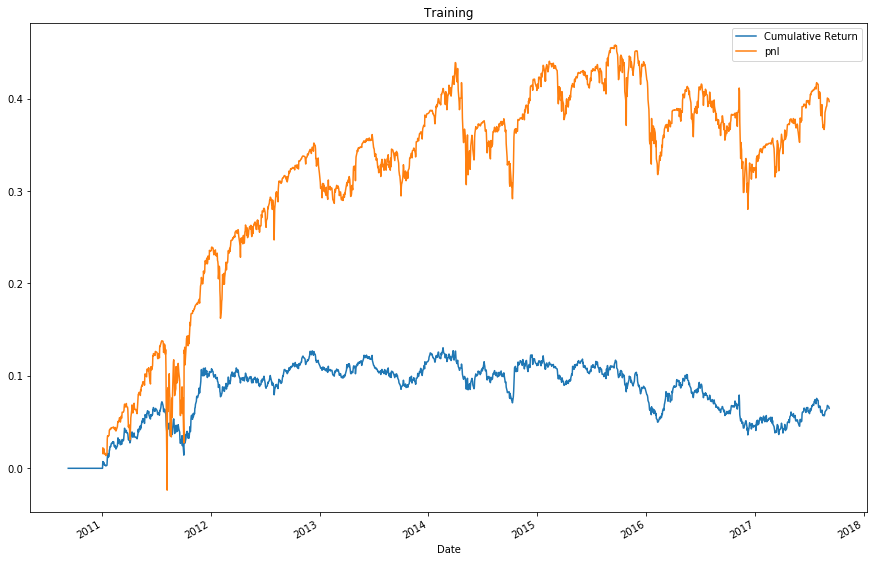

APR=0.009036 Sharpe=0.229133


In [7]:
halfLife = round(np.log(2)/lmda); #80

def linearMeanRevertingTrading(data, lookback):
    ratio = data["Ratio"];
    price = data[["SP500", "Russell"]];
    zScore = (ratio-ratio.rolling(lookback).mean())/ratio.rolling(lookback).std();
    numUnits = -zScore # captical invested
    positions = pd.DataFrame(np.tile(numUnits.values, [2, 1]).T * np.array([1, -1]) ) # positions in dollar invested
    positions.columns = ["SP500", "Russell"];
    pnl=np.sum((positions.shift().values)*(price.pct_change().values), axis=1) # daily P&L of the strategy
    ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
    ret.fillna(0, inplace=True)
    res=pd.DataFrame({"Cumulative Return":(np.cumprod(1+ret) - 1)})
    res["pnl"] = pd.DataFrame(pnl).cumsum();
    res["Return"] = ret;
    res.set_index(data.index, inplace=True);
    APR=np.prod(1+ret)**(252/len(ret))-1;
    Sharpe=np.sqrt(252)*np.mean(ret)/np.std(ret);
    return Sharpe, APR, positions, res;

Sharpe, APR, pos, res= linearMeanRevertingTrading(train, halfLife);
res[["Cumulative Return", "pnl"]].plot(figsize=(15,10))
plt.title("Training");
plt.show();
print('APR=%f Sharpe=%f' % (APR, Sharpe))

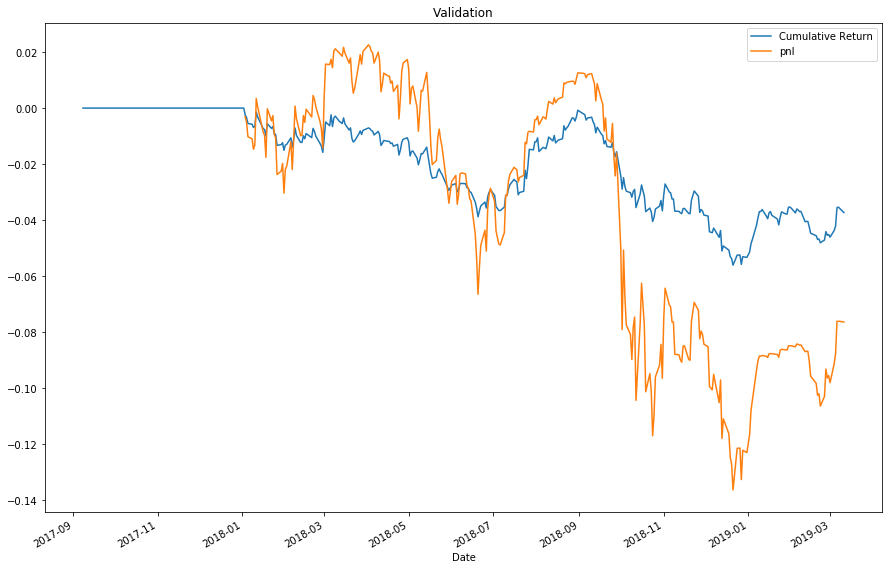

APR=-0.025112 Sharpe=-0.704885


In [8]:
Sharpe, APR, pos, res= linearMeanRevertingTrading(validate, halfLife);
res[["Cumulative Return", "pnl"]].plot(figsize=(15,10))
plt.title("Validation")
plt.show();
print('APR=%f Sharpe=%f' % (APR, Sharpe))

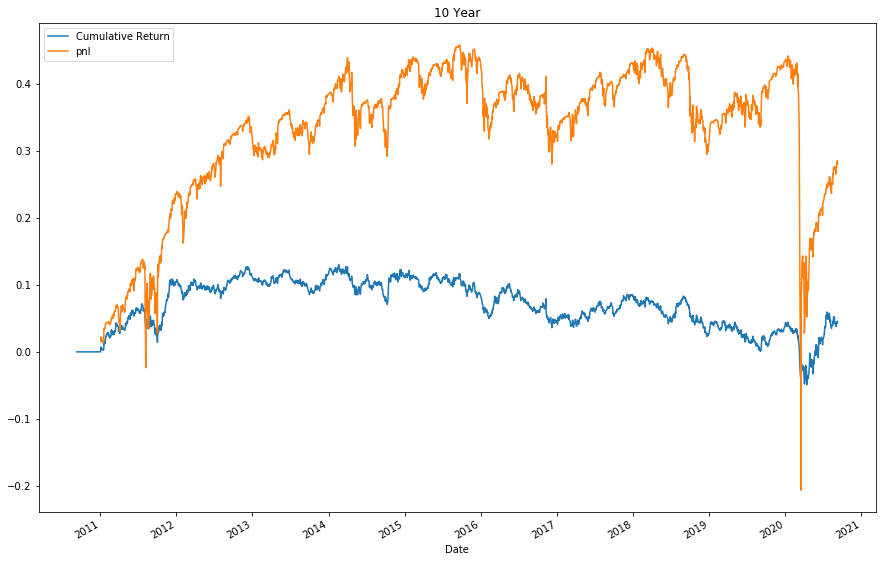

APR=0.004216 Sharpe=0.111219


In [9]:
Sharpe, APR, pos, res= linearMeanRevertingTrading(df, halfLife);
res[["Cumulative Return", "pnl"]].plot(figsize=(15,10))
plt.title("10 Year")
plt.show();
print('APR=%f Sharpe=%f' % (APR, Sharpe))

We apply the linear reverting strategy on training data, validation data and the entrie data respectively. We can see that the pnl curve is an amplified version of the cumulative return curve. This is because that we put more money when there is a bigger deviation. This method might suffer from huge fluctuations of the market. For example, if there is a huge positive deviation, we bet against the market by shorting huge positions. If the signal changes to a higher stationary mean, we lose a big fortune (see the big drawndown of the pnl curve around March 2020). Another drawback of this method is that we need to adjust our positions along with the signal. We need to trade fairly frequent and this introduces unnecessary transaction cost.

### Bollinger Band
Suppose we only enter the market if the signal is too high or too low. Then the problem is to determine when to enter/exit the market. Let's set two thresholds
$$z_{in} \geq z_{out}$$
If the signal is at least $z_{in}$ standard deviation above the mean, we short (short Russell 2000). If the signal go back to $z_{out}$ standard deviation from its mean, we clear the short positions. Similarly,if the signal is at least $-z_{in}$ standard deviation below the mean, we long (long S&P500). If the signal go back to $-z_{out}$ standard deviation from its mean, we clear the long positions.

For simplicity, we set $z_{out} = 0$ and optimize over $z_{in}$.

In [10]:
def bollinger(data, lookback, entryZscore, exitZscore):
    ratio = data["Ratio"];
    price = data[["SP500", "Russell"]];
    zScore = (ratio-ratio.rolling(lookback).mean())/ratio.rolling(lookback).std();
    longsEntry=zScore < -entryZscore
    longsExit =zScore > -exitZscore
    shortsEntry=zScore > entryZscore
    shortsExit =zScore < exitZscore
    numUnitsLong=np.zeros([len(longsEntry),1])
    numUnitsLong[:]=np.nan
    numUnitsShort=np.zeros([len(longsEntry),1])
    numUnitsShort[:]=np.nan
    numUnitsLong[0]=0
    numUnitsLong[longsEntry]=1
    numUnitsLong[longsExit]=0
    numUnitsLong=pd.DataFrame(numUnitsLong)
    numUnitsLong.fillna(method='ffill', inplace=True)
    numUnitsShort[0]=0
    numUnitsShort[shortsEntry]=-1
    numUnitsShort[shortsExit]=0
    numUnitsShort=pd.DataFrame(numUnitsShort)
    numUnitsShort.fillna(method='ffill', inplace=True)
    positions = numUnitsLong;
    positions["Short"] = numUnitsShort
    positions.columns = ["SP500", "Russell"];
    pnl=np.sum((positions.shift().values)*(price.pct_change().values), axis=1) # daily P&L of the strategy
    ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
    ret.fillna(0, inplace=True)
    res=pd.DataFrame({"CumuReturn":(np.cumprod(1+ret) - 1)})
    res["pnl"] = pd.DataFrame(pnl).cumsum();
    res["Return"] = ret;
    res.set_index(data.index, inplace=True);
    APR=np.prod(1+ret)**(252/len(ret))-1;
    Sharpe=np.sqrt(252)*np.mean(ret)/np.std(ret);
    return Sharpe, APR, positions, res;


def calculateMaxDD(cumret):
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
             
    maxDD, i=np.min(drawdown), np.argmin(drawdown) # drawdown < 0 always
    maxDDD=np.max(drawdownduration)
    return maxDD, maxDDD, i


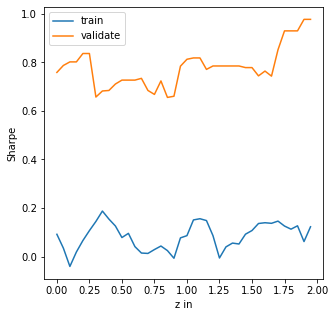

In [11]:
entryZscores = np.arange(0, 2, 0.05);
trainSharpe = [];
validateSharpe = [];
for z in entryZscores:
    trainSharpe.append(bollinger(train, halfLife, z, 0)[0]);
    validateSharpe.append(bollinger(validate, halfLife, z, 0)[0]);

plt.figure(figsize=(5,5))
plt.plot(entryZscores, trainSharpe, label = "train");
plt.plot(entryZscores, validateSharpe, label = "validate");
plt.ylabel("Sharpe");
plt.xlabel("z in")

plt.legend()

plt.show()

We should pick the $z_{in}$ such that:
1) The Sharpe ratio for both training and validation are high

2) Not too high, otherwise, it is unlikely for us to enter the market

We pick 
$$z_{in} \approx 1.1$$

APR=0.029351 Sharpe=0.246437
Max Drawdown: -0.3314290960391355


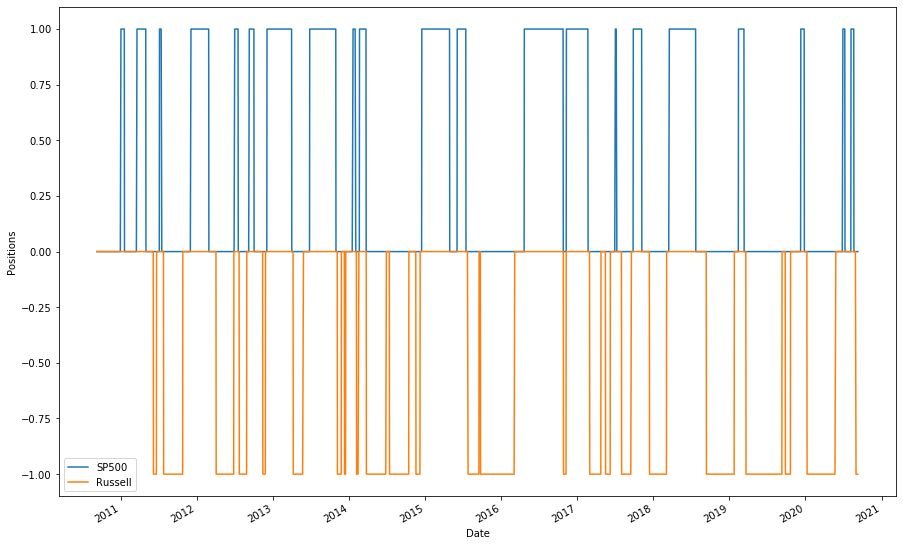

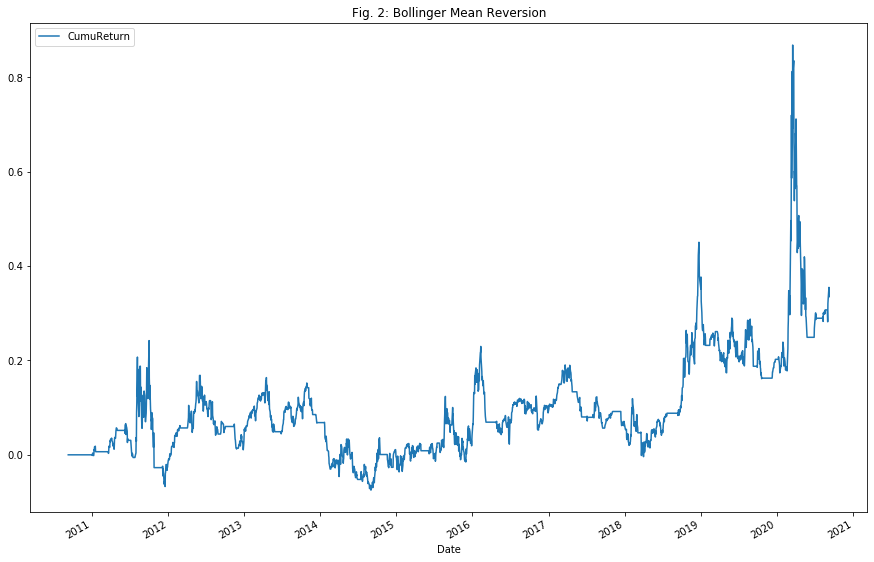

In [12]:
Sharpe, APR, pos, res = bollinger(df, halfLife, 1.1, 0);

pos.set_index(dateIndex, inplace=True)
pos.plot(figsize=(15,10));
plt.ylabel("Positions");

MaxDD, _, _ = calculateMaxDD(res["CumuReturn"])
res[["CumuReturn"]].plot(figsize=(15,10));
plt.title("Fig. 2: Bollinger Mean Reversion");
print('APR=%f Sharpe=%f' % (APR, Sharpe))
print("Max Drawdown:", MaxDD);


### Summay
#### Ratio
1. Use the Ornstein-Uhlenbeck (OU) model to predict the ratio (See Fig.1).
2. Predicted Mean: 2.1415424327007795
3. Predicted 95% Confidence Interval: [1.386687, 2.896397]

#### Bollinger Strategy
1. halfLife = 80
2. Use moving average to compute zScore of the signal with window length 80 (same as halfLife)
3. Enter the market with zEntryScore 1.1, zExitScore 0
4. APR=0.029351 
5. Sharpe Ratio=0.246437
6. Max Drawdown: -0.3314290960391355
7. PnL curve (see Fig 2)